# Co-drying of methanol and toluol from poly-(vinylacetate)

This jupyter notebook models the co-drying of two solvents,from a polymer and demonstrate the power of diffusionpy.
First we import the diffusion model and the pc-saft implementation from diffusionpy

In [1]:
import numpy as np
from diffusionpy import Diffusion_MS,vpure,dlnai_dlnxi,D_Matrix,Diffusion_MS_iter,origin_like,lngi,dlnai_dlnxi_loop
import matplotlib.pyplot as plt
plt.rcdefaults()

The experimental data for this example was taken from Schabel et al. 2006 (https://doi.org/10.1016/j.ces.2006.12.062)

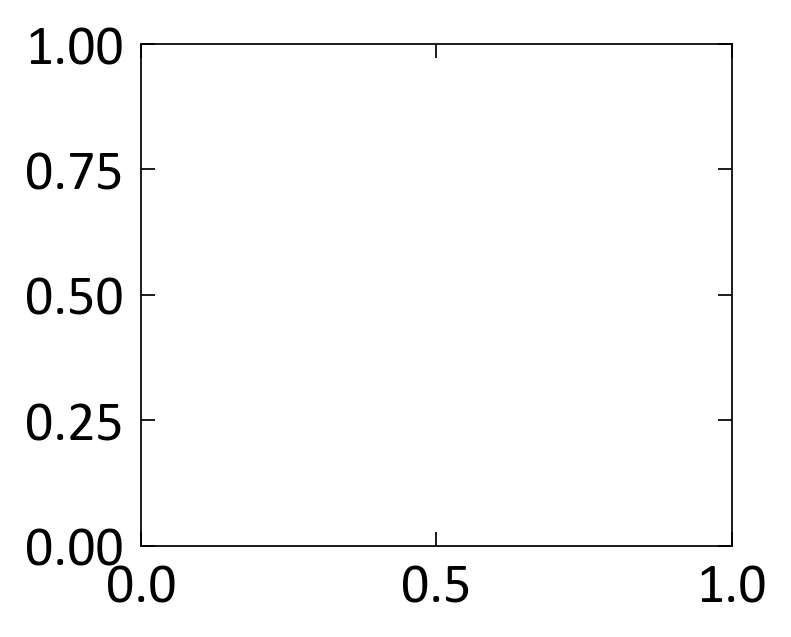

In [2]:
texp=np.asarray([0,4.427792916,14.50035208,23.87257753,33.76909653,45.58674953,58.69408811,71.80142669,91.44521324,120.9089796,147.0930411,177.8656278,212.5493678,264.9136638,429.8518201])

wpvac=np.asarray([0.333333333,0.397028757,0.559683846,0.704648614,0.763915741,0.791401827,0.801167219,0.822653035,0.830878575,0.841458325,0.846286716,0.857199094,0.851138308,0.858388537,0.8723936549])

wtol=np.asarray([0.333333333,0.361083897,0.34858624,0.273123698,0.22781745,0.202716913,0.188759833,0.17692216,0.169121425,0.158541675,0.153713284,0.142800906,0.143816828,0.137082518,0.123003508])

wmet=np.asarray([0.333333333,0.241887346,0.091729914,0.022227687,0.008266808,0.00588126,0.010072947,0.000424805,0,0,0,0,0,0,0])

origin_like.subplots()

zexp1=np.asarray([1.9474,4.8216,4.9238,6.5452,11.1408,13.4856,13.5108,15.7391,20.0811,21.531,22.3125,24.4252,29.9245,30.8605,38.8925,47.3389,55.6328])/90.
meth=np.asarray([0.23319,0.7155,1.51472,0.19766,0.14607,1.48775,0.68454,0.11456,0.07899,1.42055,0.53311,0.05949,1.0763,0.39771,1.22609,1.29549,1.17211])/1.6*1

zexp2=np.asarray([0.8693,2.3874,2.8598,4.0545,4.6346,4.9451,6.6285,6.8366,9.8909,11.5564,12.0909,12.6496,13.2874,15.4473,15.6765,18.0826,20.7233,21.026,21.1068,21.9164,21.9851,24.6318,29.6695,30.2134,37.6273,45.746,53.6665])/90.
tolu=np.asarray([0.119214,0.224938,0.119364,0.581156,0.123559,0.336155,0.191408,0.122371,0.111769,0.18907,0.111935,0.508688,0.362508,0.109479,0.16636,0.098846,0.154557,0.092297,0.52828,0.337432,0.081538,0.133187,0.477474,0.25411,0.48078,0.516594,0.404811])/0.6*1



The drying starts from a mixture of methanol-toloul-PVAc in equal parts. We define the temperature, the presssure, the number of components, their molar mass and the starting and equilibrium weight fractions.

In [3]:
T=298.15
p=1E5
nc=3 # number of components
L=2.32E-5 # estimated thickness of the film
wi0=np.asarray([0.333333333,0.333333333,0.333333333]) # Weight fractions of the components methanol, toluol and PVAc at t=0
wi8=np.asarray([0.00001,0.127606346,0.872393654]) # Weight fractions of the components methanol, toluol and PVAc at t=8.T
Mi=np.asarray([32.04,92.14,90000.])

For describing the diffusion in the mixture, a matrix of diffusion coefficients needs to be defined. The matrix for a ternary system is displayed below:


$\hat{Ð} =$ 
$\left[\begin{array}{rrr} 
0 & Ð_{12} & Ð_{13} \\ 
Ð_{21} & 0 & Ð_{23} \\ 
Ð_{31} & Ð_{32} & 0 \\ 
\end{array}\right]$

where $\hat{Ð}$ is the matrix of diffusion coefficients and $Ð_{ij}$ are the binary diffusion coefficients of component i moving in j. Friction between the same species is not required, thus $Ð_{ii}=0$  
Furthermore, the Stefan-Maxwell diffusion coefficients used in diffusionpy retain a convenient property where each pair of binary diffusion coefficients is symmetric i.e $Ð_{ij}=Ð_{ji}$

Thus, for describing the diffusion in a ternary system, only three binary diffusion coefficients need to be defined:

$Ð_{vec} = \left[\begin{array}{rrr} Ð_{12} & Ð_{13} & Ð_{23} \end{array}\right]$

which is stored as a vector of length $\frac{n_c(1-n_c)}{2}$ with $n_c$ being the number of components

In [4]:
Dvec=np.asarray([1E-5,9E-10,1E-9])
Dvec=np.asarray([1E-5,2E-10,8E-10])

Diffusionpy internally caclulates the matrix $\hat{Ð}$ using the D_Matrix functionality

In [5]:
Dmat=D_Matrix(Dvec,nc)

Lastly, one needs to specify which components is considered mobile and which immobile. In our case, the solvents are obviously mobile while the polymer can be considered immobile due to its large molar mass which is conveniently defined as a boolean array.

In [6]:
mobile=np.asarray([True,True,True])

Finally, we can model solvent desorption and plot the results

In [7]:
nt=20
t=np.linspace(0,texp[-1]**0.5,nt)**2    
import time

wt=Diffusion_MS(t,L,Dvec,wi0,wi8,Mi,mobile,nz=20)


------------- Initialization and postprocessing ----------------
------------- Start diffusion modeling ----------------
------------- Diffusion modeling took 0.0896939 seconds ----------------
------------- Initialization and postprocessing took 5.125168 seconds----------------


diffusionpy neglects non-idealities for the default case. If the user wants to consider non-idealities a thermodynamic model is needed. 
diffusionpy comes prepackaged with an implementation of the pc-saft equation of state. 
PC-SAFT parameteters can be defined as follows:

In [8]:
kij=D_Matrix(np.asarray([0.029,-0.05855362,0.027776682]),nc)
par={"mi":np.asarray([1.5255, 2.8149, 2889.9]),
"si": np.asarray([3.2300, 3.7169, 3.3972]),
"ui" :np.asarray([188.9, 285.69, 204.65]),
"eAi" :np.asarray([2899.5, 0., 0.]),
"kAi":np.asarray([0.035176, 0., 0.]),
"NAi":np.asarray([1., 0., 1047.]),
"Mi": Mi,
"kij":kij,
"kijA":np.asarray([[0.]])}


However, any other implementatation of any thermodyamic model can be used in conjucntion with diffusionpy. 
This is because, diffusionpy relies soley on the numerical values of second derivative of activities $a_i$ or fugacities $f_i$ of component i. 

$\frac{Dlna_i}{Dlnx_i}$ = $\frac{Dlnf_i}{Dlnx_i}$ , where $D$ denotes that the differentiation was performed while neglecting the mass balance.

The nonidealities employed in an iterative fashion and are supplied for each time point for the current weight fraction -time matrix. Here, the ideal solution from before gives the initial point for the iteration. 

In [9]:
vpures=vpure(p,T,**par)
par["vpure"]=vpures
nonidealities=np.asarray([dlnai_dlnxi(T,wt[i,:],**par) for i in range(nt)]).T
# dlnai_dlnwi_fun=lambda wi: dlnai_dlnxi(T,wi,**par)
dlnai_dlnwi_fun=lambda wi: dlnai_dlnxi_loop(T,wi,**par)

In esssence, the iteration was performed by using a simple fixed point iteration. 
Alternatively, if one uses the built-in PC-SAFT implementation, diffusiopy offers a more sophisticated functioniality for this iteration based the df-sane algoirthm.
Additionally, full output can specified in order to recieve e.g the spatial information of the concentrations

We can plot the time and spatial profiles of methanol and toluene

Finally, diffusionpy provides an interface to change the boundary conditions. For example here, we provide a time-dependant surface cocnentartion to consider that the surface concentration needs time to establish due to gassided diffusion limitations

In [10]:
taui=np.asarray([5,55])
from diffusionpy.surface_activity import time_dep_surface
witB=time_dep_surface(t,wi0,wi8,mobile,taui)

wt,wtz,zvec,Lt=Diffusion_MS_iter(t,L,Dvec,wi0,wi8,Mi,mobile,swelling=True,full_output=True,dlnai_dlnwi_fun=dlnai_dlnwi_fun,method="weg",maxit=9,witB=witB,nz=20)
# wt,wtz,zvec,Lt=Diffusion_MS_iter(t,L,Dvec,wi0,wi8,Mi,mobile,full_output=True,dlnai_dlnwi_fun=dlnai_dlnwi_fun,witB=witB,maxit=20,method="wegstein")

# wt,wtz,zvec,Lt=Diffusion_MS(t,L,Dvec,wi0,wi8,Mi,mobile,full_output=True,witB=witB)
# for i in range(5):
#     dlnai_dlnwi=np.asarray([[dlnai_dlnwi_fun(col) for col in row.T] for row in wtz])
#     wt,wtz,zvec,Lt=Diffusion_MS(t,L,Dvec,wi0,wi8,Mi,mobile,full_output=True,dlnai_dlnwi=dlnai_dlnwi,witB=witB)


------------- Initialization and postprocessing ----------------


------------- Start diffusion modeling ----------------
------------- Diffusion modeling took 0.1589822 seconds ----------------
------------- Initialization and postprocessing took 0.1058702 seconds----------------
------------- Start PC-SAFT modeling ----------------
------------- PC-SAFT modeling took 0.0848312 seconds ----------------
------------- Initialization and postprocessing ----------------
------------- Start diffusion modeling ----------------
------------- Diffusion modeling took 0.266579 seconds ----------------
------------- Initialization and postprocessing took 0.1208776 seconds----------------
------------- Start PC-SAFT modeling ----------------
------------- PC-SAFT modeling took 0.0916013 seconds ----------------
------------- Initialization and postprocessing ----------------
------------- Start diffusion modeling ----------------
------------- Diffusion modeling took 0.2797711 seconds ----------------
------------- Initialization and postprocessing took 0.12716

In [11]:
# wt,wtz,zvec,Lt=Diffusion_MS_iter(t,L,Dvec,wi0,wi8,Mi,mobile,full_output=True,dlnai_dlnwi_fun=dlnai_dlnwi_fun,witB=witB)

# lngi_fun=lambda wi: lngi(T,wi,**par)

# wt,wtz,zvec,Lt=Diffusion_MS(t,L,Dvec,wi0,wi8,Mi,mobile,full_output=True)
# for i in range(5):
#         lngi_tz=np.asarray([[lngi_fun(col) for col in row.T] for row in wtz])
#         wt,wtz,zvec,Lt=Diffusion_MS(t,L,Dvec,wi0,wi8,Mi,mobile,full_output=True,lngi_tz=lngi_tz,witB=witB)

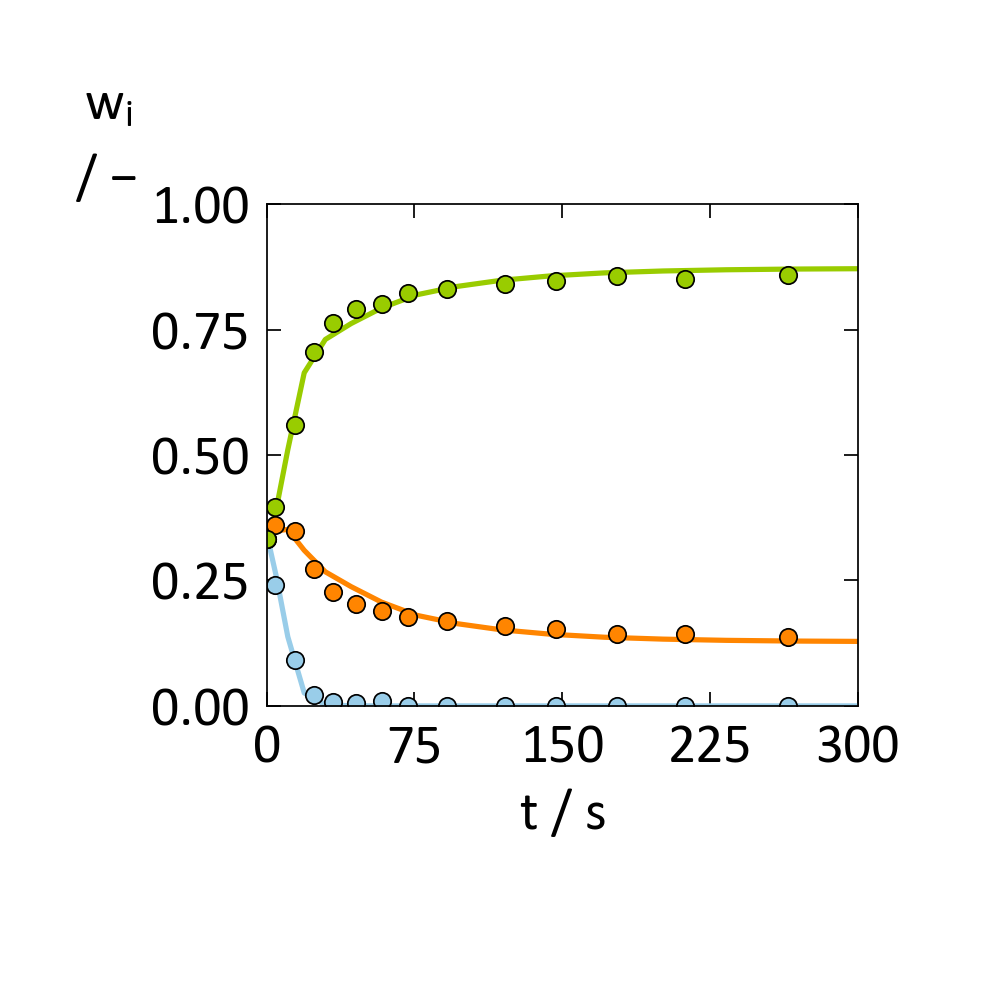

In [12]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

color1 = "#99CDE9"
color2 = "#F08208"
color3 = "#99CC00"

fig,ax=origin_like.subplots()

origin_like.plot(ax,t,wt[:,0],"c-")
origin_like.plot(ax,t,wt[:,1],"r-")
origin_like.plot(ax,t,wt[:,2],"g-")
origin_like.plot(ax,texp,wmet,"co")
origin_like.plot(ax,texp,wtol,"ro")
origin_like.plot(ax,texp,wpvac,"go")
origin_like.set_xlabel(ax,"t","s")
origin_like.set_ylabel(ax,"w_i","-")
origin_like.set_ticks(ax,0,300,0,1)
plt.show()

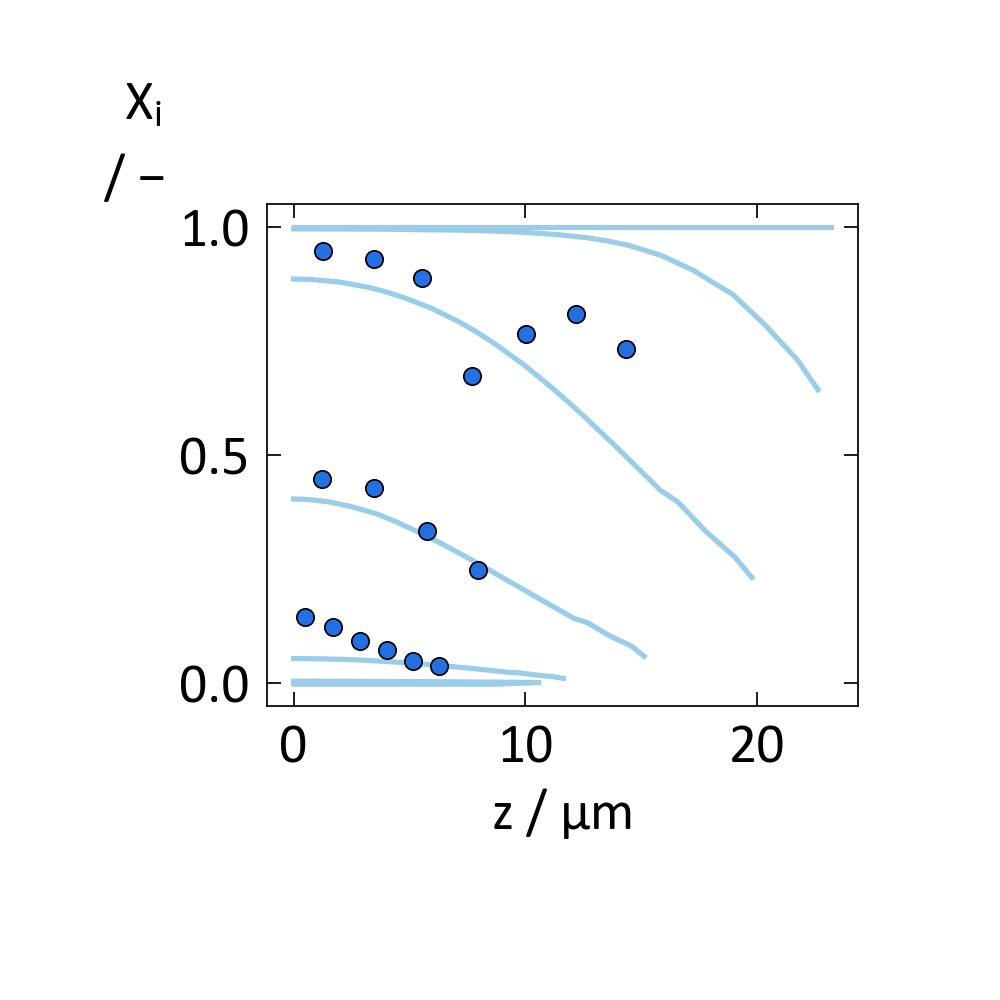

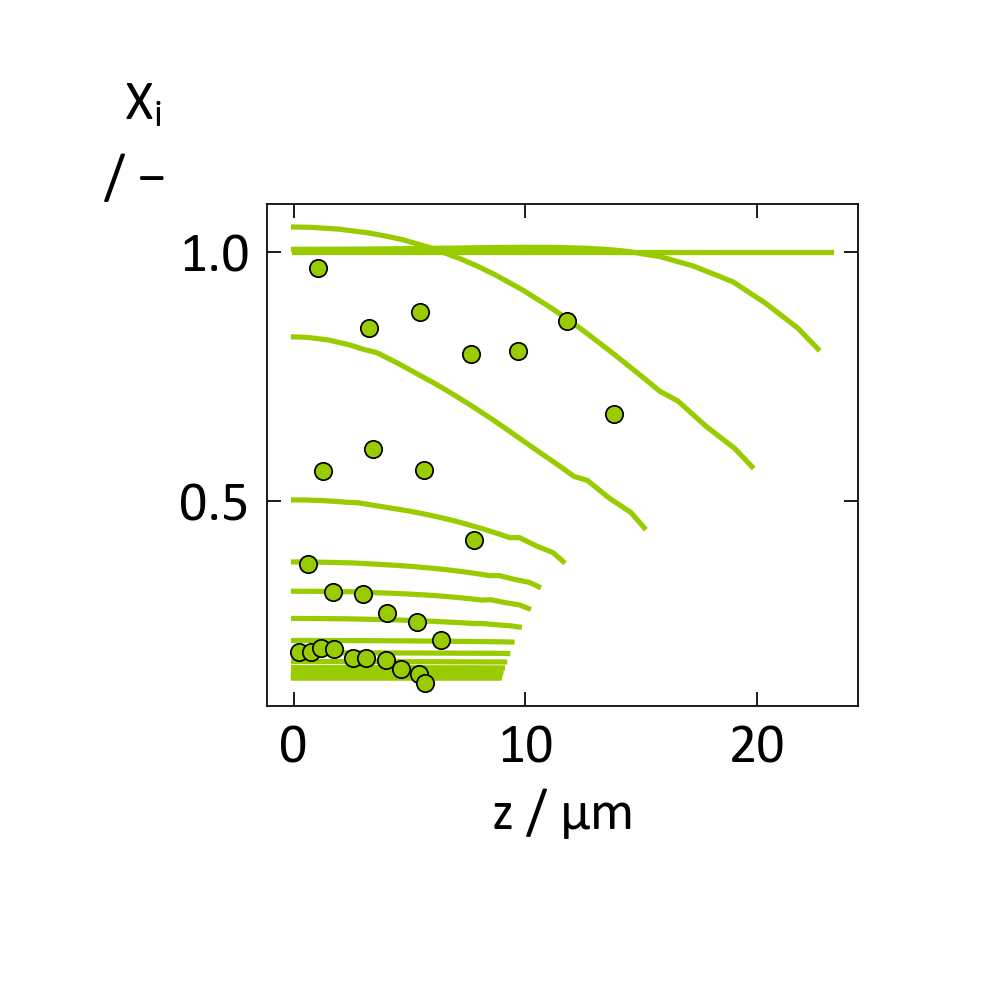

In [13]:
fig3, ax3 = origin_like.subplots()
origin_like.set_xlabel(ax3,"z"," µm")
origin_like.set_ylabel(ax3,"X_i","-")
[origin_like.plot(ax3,Lt[i]/Lt[0]*zvec*1E6,wtz[i,0,:]/wtz[i,2,:],"c-") for i,val in enumerate(wtz[:,0,0])]
# [origin_like.plot(ax3,zvec*1E6,wtz[i,0,:]/wtz[i,2,:],"c-") for i,val in enumerate(wtz[:,0,0])]
origin_like.plot(ax3,zexp1*Lt[0]*1E6,meth, "bo")

fig4, ax4 = origin_like.subplots()
origin_like.set_xlabel(ax4,"z"," µm")
origin_like.set_ylabel(ax4,"X_i","-")
[origin_like.plot(ax4,Lt[i]/Lt[0]*zvec*1E6,wtz[i,1,:]/wtz[i,2,:],"g-") for i,val in enumerate(wtz[:,0,0])]
# [origin_like.plot(ax4,zvec*1E6,wtz[i,1,:]/wtz[i,2,:],"g-") for i,val in enumerate(wtz[:,0,0])]
origin_like.plot(ax4,zexp2*Lt[0]*1E6,tolu, "go")

In Triangular diagram


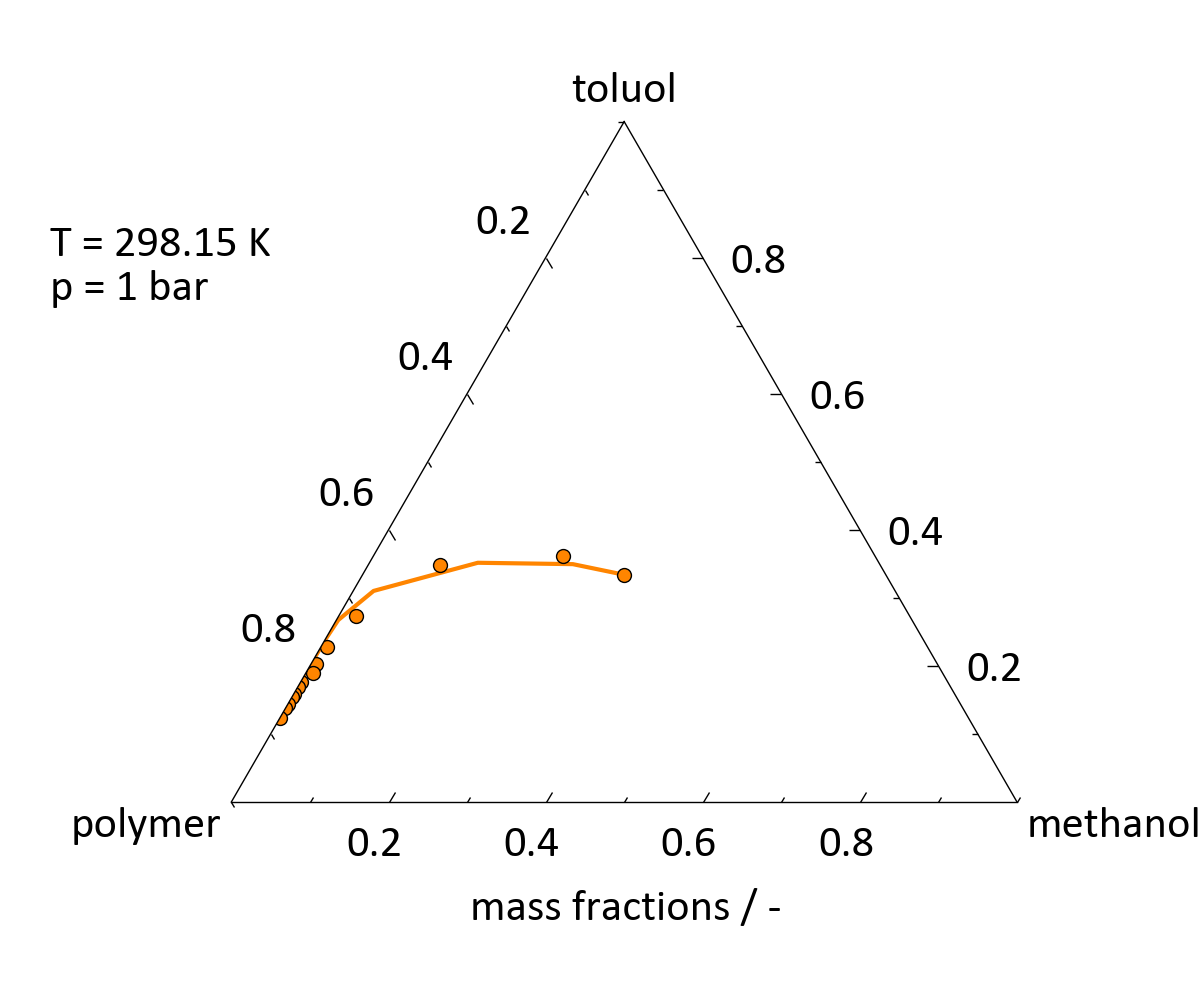

In [14]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

figt,axt=origin_like.ternary()
origin_like.plot(axt,wtol,wpvac,"ro",z=wmet,order=2)
origin_like.plot(axt,wt[:,1],wt[:,2],"r-",z=wt[:,0],order=1)
origin_like.set_labels(axt,label="mass fractions / -",title="T = 298.15 K \np = 1 bar",xlabel='toluol',ylabel='polymer',zlabel="methanol")
ticks=np.linspace(0, 1, 6)
ticks_zero_one_less=ticks[np.logical_and(ticks!=0,ticks!=1)]
axt.taxis.set_ticks(ticks_zero_one_less)
axt.laxis.set_ticks(ticks_zero_one_less)
axt.raxis.set_ticks(ticks_zero_one_less)